<a href="https://colab.research.google.com/github/levimcclenny/notebooks/blob/main/Notebook4_Helmholtz_SteadyState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorDiffEq for Helmholtz


$ u_{xx} + u_{yy} + k^2u - q(x,y) = 0  $ \\
\
$ u(-1,y) = u(1,y) = u(x,-1) = u(x,1) = 0 $ \\
\
where $x \in [-1,1], y \in [-1,1]$ and \\
\
$ q(x,y) = -\  (a_1\pi)^2\sin(a_1\pi x)\sin(a_2\pi y) - \ (a_2\pi)^2\sin(a_1\pi x)\sin(a_2\pi y) + \ k^2\sin(a_1\pi x)\sin(a_2\pi y)  $ \\
\
is a forcing term that results in a closed-form analytical solution \\
\
\begin{equation}
    u(x,y) = \sin(a_1\pi x)\sin(a_2\pi y)\,.
\end{equation}

## pip install tensordiffeq

In [1]:
!pip install tensordiffeq

     |████████████████████████████████| 870kB 6.5MB/s 
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-cp37-none-any.whl size=25519 sha256=3ad6dca71aaa2ec7e9bfa3db1328a96c8f95ffbf79a135c5edd27f2598a7bda8
  Stored in directory: /root/.cache/pip/wheels/60/88/1d/b334ee00dd83e82d111ec56c3be91573d335c93870698037f1
Successfully built pyDOE2


In [2]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensordiffeq as tdq
from tensordiffeq.boundaries import *
from tensordiffeq.models import CollocationSolverND
from tensorflow.math import sin
from tensordiffeq.utils import constant

from tensordiffeq.plotting import *

Domain = DomainND(["x", "y"])

Domain.add("x", [-1.0, 1.0], 1001)
Domain.add("y", [-1.0, 1.0], 1001)

N_f = 10000
Domain.generate_collocation_points(N_f)


def f_model(u_model, x, y):
    u = u_model(tf.concat([x, y], 1))
    u_x = tf.gradients(u, x)[0]
    u_y = tf.gradients(u, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]

    a1 = constant(1.0)
    a2 = constant(4.0)
    ksq = constant(1.0)
    pi = constant(math.pi)

    # we use this specific forcing term because we have an exact analytical solution for this case
    # to compare the results of the PINN solution
    # note that we must use tensorflow math primitives such as sin, cos, etc!
    forcing = - (a1 * pi) ** 2 * sin(a1 * pi * x) * sin(a2 * pi * y) - \
              (a2 * pi) ** 2 * sin(a1 * pi * x) * sin(a2 * pi * y) + \
              ksq * sin(a1 * pi * x) * sin(a2 * pi * y)

    f_u = u_xx + u_yy + ksq * u - forcing  # = 0

    return f_u


upper_x = dirichletBC(Domain, val=0.0, var='x', target="upper")
lower_x = dirichletBC(Domain, val=0.0, var='x', target="lower")
upper_y = dirichletBC(Domain, val=0.0, var='y', target="upper")
lower_y = dirichletBC(Domain, val=0.0, var='y', target="lower")

BCs = [upper_x, lower_x, upper_y, lower_y]

layer_sizes = [2, 50, 50, 50, 50, 1]

model = CollocationSolverND()
model.compile(layer_sizes, f_model, Domain, BCs)

# TDQ example has 10k,10k - here 3k per adam/adam works. With SA-PINN more iterations are required.
# More iterations here will yield more accuracy, of course.
model.fit(tf_iter=3000, newton_iter=3000)



  ______                           ____  _ ______________     
 /_  __/__  ____  _________  _____/ __ \(_) __/ __/ ____/___ _
  / / / _ \/ __ \/ ___/ __ \/ ___/ / / / / /_/ /_/ __/ / __ `/
 / / /  __/ / / (__  ) /_/ / /  / /_/ / / __/ __/ /___/ /_/ / 
/_/  \___/_/ /_/____/\____/_/  /_____/_/_/ /_/ /_____/\__, /  
                                                        /_/   

Neural Network Model Summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)    


Starting L-BFGS training
Executing eager-mode L-BFGS


## Plotting

In [3]:
# get exact solution
nx, ny = (1001, 1001)
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)

xv, yv = np.meshgrid(x, y)

x = np.reshape(x, (-1, 1))
y = np.reshape(y, (-1, 1))

# Exact analytical soln is available:
Exact_u = np.sin(math.pi * xv) * np.sin(4 * math.pi * yv)

# Flatten for use
u_star = Exact_u.flatten()[:, None]

# Plotting
x = Domain.domaindict[0]['xlinspace']
y = Domain.domaindict[1]["ylinspace"]

X, Y = np.meshgrid(x, y)

# print(np.shape((X,Y))) # 2, 256, 256
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

lb = np.array([-1.0, -1.0])
ub = np.array([1.0, 1])

u_pred, f_u_pred = model.predict(X_star)

error_u = tdq.helpers.find_L2_error(u_pred, u_star)
print('Error u: %e' % (error_u))


Error u: 2.101772e-02


The above error is the L2 error across the entire domain for all 1m points in the domain. So the actual error per timestep is relatively small. There are 1000 timesteps, so we can appriximate an error of the above number % 1000 for the avg residual at each timestep. 

Manual plotting for a bug where the transpose of the solution is displayed. Will be repaired in a later release. 

No handles with labels found to put in legend.


Text(0.5, 1.0, '$x = 0.50$')

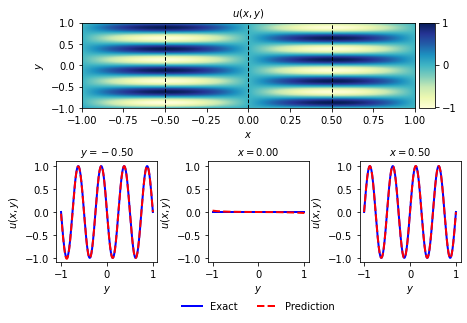

In [4]:
U_pred = tdq.plotting.get_griddata(X_star, u_pred.T.flatten(), (X, Y))
FU_pred = tdq.plotting.get_griddata(X_star, f_u_pred.T.flatten(), (X, Y))

fig, ax = newfig(1.3, 1.0)
ax.axis('off')

####### Row 0: h(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred, interpolation='nearest', cmap='YlGnBu',
              extent=[lb[1], ub[1], lb[0], ub[0]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(y[250]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(y[500]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(y[750]*np.ones((2,1)), line, 'k--', linewidth = 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
leg = ax.legend(frameon=False, loc = 'best')

ax.set_title('$u(x,y)$', fontsize = 10)

####### Row 1: h(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_u[:,250], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,250], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.set_title('$y = %.2f$' % (y[250]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_u[:,500], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,500], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$x = %.2f$' % (y[500]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_u[:,750], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[:,750], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$x = %.2f$' % (y[750]), fontsize = 10)